In [40]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase

from analysis.weekly_analysis import WeeklyAnalysis as anas

## risk and return class imports
from returns.products import Products as returns_products_class

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [41]:
market = Market()

In [42]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [43]:
tyields = returns_products_class.tyields()
bench_returns = returns_products_class.spy_bench()

In [59]:
db_name = "weekly"
if "btc" in db_name:
    positions = 1
else:
    positions = 10
speculation_db = ADatabase(db_name)
speculation_db.connect()
t = speculation_db.retrieve("trades")
speculation_db.disconnect()

In [60]:
trades = []
values = [True,False]
classifications = [True,False]
ceilings = [True,False]
floors = [True,False]
parameters = []
strats = ["spec","rolling","window"]
for strat in strats:
    for value in values:
        for classification in classifications:
            for ceiling in ceilings:
                for floor in floors:
                    parameter = {
                                "value":value
                                 ,"classification":classification
                                 ,"ceiling":ceiling
                                 ,"floor":floor
                                ,"strat":strat
                                }
                    parameters.append(parameter)

In [61]:
analysis = []
indexer = list(parameters[0].keys())
for parameter in parameters:
    try:
        ledger = t.sort_values(["year","week"]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

In [62]:
a

,value,classification,ceiling,floor,strat,pv,beta,rrr,sharpe
137,True,True,True,True,spec,2.040680,-0.832924,0.950945,-1.186519
137,True,True,True,False,spec,0.741662,-1.782901,0.835232,0.174288
137,True,True,False,True,spec,2.116893,-0.768243,0.958823,-1.385620
137,True,True,False,False,spec,0.909369,-1.477046,0.872487,0.096836
137,True,False,True,True,spec,2.146767,-0.688128,0.968582,-1.590353
137,True,False,True,False,spec,0.642983,-1.518297,0.867462,0.269655
137,True,False,False,True,spec,2.091097,-0.592004,0.980290,-1.754546
137,True,False,False,False,spec,0.704061,-0.984673,0.932461,0.353761
137,False,True,True,True,spec,1.477528,-1.009560,0.929430,-0.421102
137,False,True,True,False,spec,0.992809,-1.420536,0.879370,0.041950


In [63]:
a.sort_values("pv",ascending=False).groupby("strat").first().reset_index().sort_values("pv")

,strat,value,classification,ceiling,floor,pv,beta,rrr,sharpe
1,spec,True,False,True,True,2.146767,-0.688128,0.968582,-1.590353
0,rolling,True,False,True,True,2.357025,0.269258,1.085197,4.845266


In [64]:
top = a.sort_values("pv",ascending=False).iloc[0]
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
ledger = analysis[["year","week","ticker","delta","delta_sign","actual_returns","position"]]
ledger = ledger.merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")

In [65]:
ledger.sort_values("actual_returns",ascending=False).head(30)

,year,week,ticker,delta,delta_sign,actual_returns,position,GICS Sector
432,2020.0,23.0,AAL,0.567535,1.0,1.656863,3,Industrials
156,2020.0,23.0,UAL,0.645552,1.0,1.417753,1,Industrials
18,2020.0,23.0,OXY,0.705291,1.0,1.409492,0,Energy
846,2020.0,23.0,SPG,0.491881,1.0,1.396375,6,Real Estate
1259,2020.0,23.0,APA,0.440560,1.0,1.313982,9,Energy
984,2020.0,23.0,DAL,0.451949,1.0,1.293449,7,Industrials
294,2020.0,23.0,NCLH,0.611411,1.0,1.289822,2,Consumer Discretionary
708,2020.0,23.0,CCL,0.514650,1.0,1.275044,5,Consumer Discretionary
975,2020.0,13.0,AVB,0.724653,1.0,1.257414,7,Real Estate
1122,2020.0,23.0,IVZ,0.444017,1.0,1.243728,8,Financials


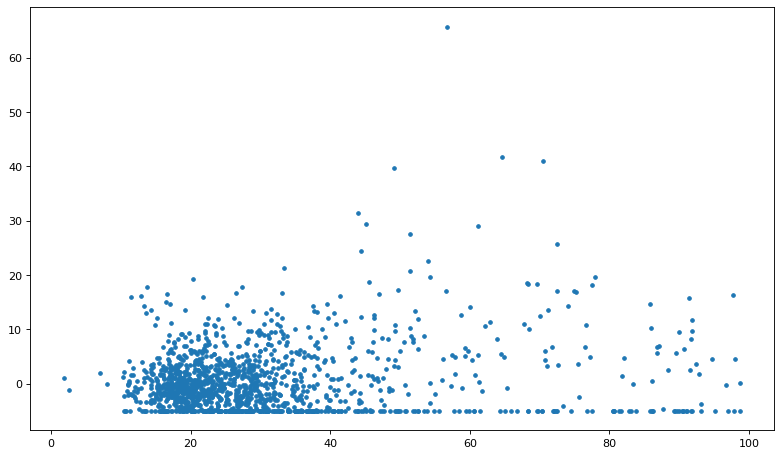

In [66]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger["delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [67]:
portfolio = ledger.pivot_table(index=["year","week"],columns="position",values="actual_returns").fillna(1).reset_index()

In [68]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [69]:
cumulative

,0,1,2,3,4,5,6,7,8,9,date_string,date,pv,adjclose,bench
0,0.979519,0.963718,0.980311,0.959985,0.976995,1.011494,0.981703,0.974663,0.988816,0.979665,2020-W2,2020-01-10,0.979687,325.71,1.000000
1,0.930543,0.957233,1.003864,0.941411,0.969093,0.967953,0.942248,0.941564,0.976324,0.985404,2020-W3,2020-01-17,0.961564,331.95,1.019158
2,0.995550,0.958525,1.086920,0.935985,0.928248,0.989406,0.976688,0.962591,0.994432,1.010777,2020-W5,2020-01-31,0.983912,321.73,0.987781
3,1.013617,0.991075,1.098327,0.889185,0.960240,1.015692,1.001117,0.918480,0.999154,1.027638,2020-W6,2020-02-07,0.991452,332.20,1.019926
4,1.011964,0.955340,1.095663,0.864229,0.967712,1.026018,1.111310,0.919557,1.000260,0.976256,2020-W7,2020-02-14,0.992831,337.60,1.036505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,4.458220,1.486630,1.287084,2.996168,2.688829,3.398157,0.952103,1.697186,1.315800,2.965039,2022-W47,2022-11-25,2.324522,402.33,1.235240
134,4.459992,1.646384,1.296496,3.380200,2.948833,3.461032,0.984761,1.697771,1.290901,3.241644,2022-W48,2022-12-02,2.440801,406.91,1.249302
135,4.534325,1.654480,1.375528,3.379816,3.058426,3.525240,0.935523,1.703148,1.390104,3.309486,2022-W49,2022-12-09,2.486608,393.28,1.207454
136,4.307609,1.571756,1.310142,3.210825,2.905504,3.348978,0.888747,1.617990,1.400690,3.289654,2022-W50,2022-12-16,2.385190,383.27,1.176722


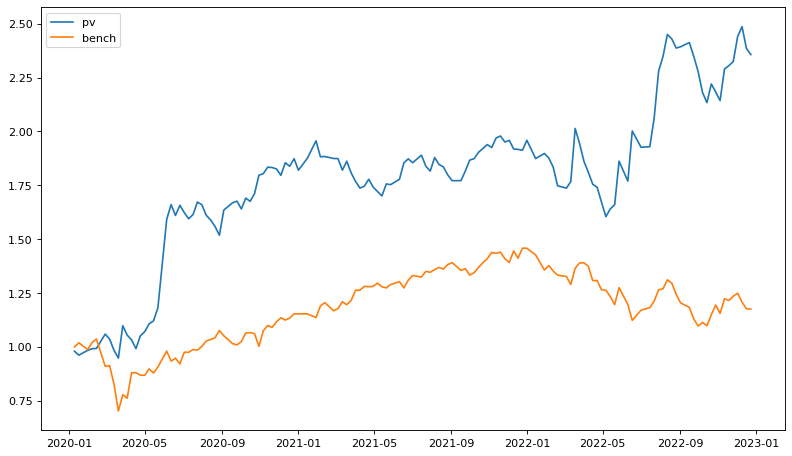

In [70]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

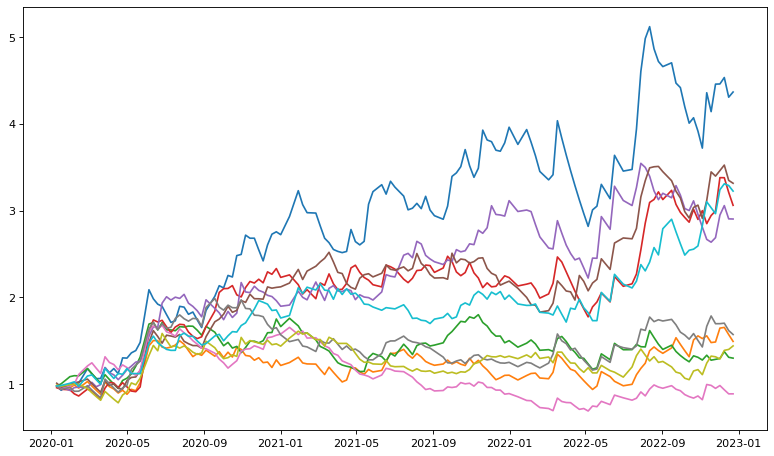

In [71]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)

plt.show()


In [72]:
ledger.groupby(["GICS Sector"]).mean().sort_values("delta",ascending=False)

,year,week,delta,delta_sign,actual_returns,position
GICS Sector,,,,,,
Real Estate,2020.722222,22.361111,0.403298,0.111111,1.025195,5.916667
Financials,2020.571429,21.828571,0.400649,0.028571,1.005547,5.242857
Communication Services,2021.392857,27.028571,0.342622,0.528571,1.006041,3.757143
Industrials,2020.789916,27.806723,0.336062,-0.075630,1.007702,4.831933
Consumer Discretionary,2020.932258,30.119355,0.324627,-0.051613,1.006232,4.058065
Energy,2020.813253,23.740964,0.322131,-0.228916,1.013107,4.662651
Information Technology,2021.030303,27.674242,0.278535,-0.219697,1.003126,4.628788
Materials,2021.000000,29.973684,0.274282,-0.368421,1.001707,4.881579
Health Care,2021.100629,30.723270,0.272239,-0.031447,1.008250,4.433962


In [73]:
industry_analysis = ledger.pivot_table(index=["year","week"],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2.020000e+03,2.000000e+00,1.000000,0.974663,1.000000,1.000000,1.000000,0.977299,1.000000,0.975380,1.011494,1.000000,1.000000
1,4.080400e+06,6.000000e+00,1.000000,0.957933,1.000000,1.000000,0.987367,1.000779,1.000000,0.949179,1.011494,1.000000,1.000000
2,8.242408e+09,3.000000e+01,1.000000,0.957933,1.000000,0.957852,0.987367,1.060469,1.022163,0.970072,1.011494,1.000000,1.000000
3,1.664966e+13,1.800000e+02,1.033959,0.914035,1.000000,0.982636,0.987367,1.088643,1.032890,0.921569,1.016297,1.000000,1.016681
4,3.363232e+16,1.260000e+03,1.033959,0.904828,1.000000,0.983725,0.987367,1.208471,1.032890,0.901125,1.024205,1.000000,1.016681
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,inf,5.941791e+179,1.437300,0.973168,1.215790,1.448988,1.325582,2.358229,0.847399,1.495178,1.179925,1.601425,1.246769
134,inf,2.852060e+181,1.534668,0.972963,1.215790,1.448988,1.325582,2.497007,0.847736,1.639759,1.179925,1.601425,1.246769
135,inf,1.397509e+183,1.560246,0.978112,1.215790,1.560339,1.325582,2.516968,0.847736,1.685440,1.179925,1.601425,1.246769
136,inf,6.987546e+184,1.506403,0.947991,1.215790,1.560339,1.259303,2.391120,0.805349,1.685440,1.179925,1.601425,1.184431
